In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

## 构建模型

In [677]:
class RnnModel(nn.Module):
    def __init__(self, num_indepen, num_hiddens, num_depen):
        super(RnnModel, self).__init__()
        self.num_indepen = num_indepen
        self.rnn = nn.RNN(input_size=self.num_indepen, hidden_size=num_hiddens, num_layers=1, batch_first=True, bidirectional=True)
        self.hidden_size = self.rnn.hidden_size * (2 if self.rnn.bidirectional else 1) 
        self.linear = nn.Linear(self.hidden_size, num_depen)

    def forward(self, inputs, state=None): # inputs: (batch, step, num_indepen)
        Y, state = self.rnn(inputs, state)
        Y = self.linear(Y)
        return Y, state

In [649]:
class ReviseRnnModel(nn.Module):
    def __init__(self, num_indepen, num_hiddens1, num_hiddens2, num_depen):
        super(ReviseRnnModel, self).__init__()
        self.num_indepen = num_indepen
        self.rnn = nn.RNN(input_size=self.num_indepen, hidden_size=num_hiddens1, num_layers=1, batch_first=True)
        self.hidden_size = self.rnn.hidden_size * (2 if self.rnn.bidirectional else 1) 
        self.linear1 = nn.Linear(self.hidden_size, num_hiddens2)
        self.linear2 = nn.Linear(num_hiddens2, num_depen)

    def forward(self, inputs, state=None): # inputs: (step, batch, num_indepen)
        Y, state = self.rnn(inputs, state)
        Y = torch.relu(self.linear1(Y))
        Y = self.linear2(Y)
        return Y, state

## 生成模拟数据

In [2]:
import numpy as np
import networkx as nx
import time
import random
import multiprocessing


class Diffuse:  # 默认网络结构为节点数量为10000，边为30000的随机网络
    def __init__(self, p, q, alpha=0, sigma=0, g=nx.gnm_random_graph(10000, 30000), num_runs=35, multi_proc=False):
        '''
        p: 创新系数
        q: 模仿系数
        alpha: 邻居效应
        sigma: 个体差异性
        g: 网络
        num_runs: 仿真时间步
        '''
        self.multi_proc = multi_proc
        self.g = g.to_directed() if not nx.is_directed(g) else g
        self.nodes_array = np.array(self.g)
        self.num_runs = num_runs
        self.alpha = alpha
        self.sigma = sigma
        for i in self.g:
            self.g.nodes[i]['prede'] = list(self.g.predecessors(i))
            self.g.nodes[i]['num_prede'] = len(self.g.nodes[i]['prede'])
            self.g.nodes[i]['p'] = p*(1 + self.sigma*np.random.randn())
            self.g.nodes[i]['q'] = q*(1 + self.sigma*np.random.randn())

    def decide(self, i):
        num_adopt_prede = sum([self.g.nodes[k]['state'] for k in self.g.nodes[i]['prede']])
        prob = 1 - (1 - self.g.nodes[i]['p'])*(1 - self.g.nodes[i]['q'])**num_adopt_prede
        if self.g.nodes[i]['num_prede']:
            mi = num_adopt_prede/(self.g.nodes[i]['num_prede']**self.alpha)
        else:
            mi = 0
        prob = 1 - (1 - self.g.nodes[i]['p'])*(1 - self.g.nodes[i]['q'])**mi
        return prob > random.random()

    def update(self, non_node_array):
        len_nodes = len(non_node_array)
        state_array = np.zeros(len_nodes, dtype=bool)
        for i in range(len_nodes):
            node = non_node_array[i]
            if self.decide(node):
                self.g.nodes[node]['state'] = True
                state_array[i] = True
        return np.sum(state_array), non_node_array[state_array == False]

    def single_diffuse(self):
        for i in self.g:
            self.g.nodes[i]['state'] = False
        non_node_array = self.nodes_array[:]
        num_of_adopt = []
        for i in range(self.num_runs):
            num, non_node_array = self.update(non_node_array)
            num_of_adopt.append(num)

        return num_of_adopt

    def repete_diffuse(self, repetes=10):  # 多次扩散
        if self.multi_proc:
            if repetes < 5:
                pool = multiprocessing.Pool(processes=repetes)
            else:
                pool = multiprocessing.Pool(processes=5)
            proc = []
            for i in range(repetes):
                proc.append(pool.apply_async(self.single_diffuse))

            pool.close()
            pool.join()
            return [res.get() for res in proc]
        else:
            return [self.single_diffuse() for i in range(repetes)]

In [390]:
t1 = time.perf_counter()
pq_cont = list(zip(list(0.01*np.random.rand(10)+0.0001), list(0.1*np.random.rand(10)+0.001)))
diff_list = []
for p, q in pq_cont:
    diffu = Diffuse(p, q)
    diffu_cont = diffu.repete_diffuse(repetes=10)
    diff_list.append(diffu_cont)
    print(f"参数设置: p--{p}, q--{q} network--{diffu.g.number_of_nodes()}")
    print(f"用时{time.perf_counter() - t1:.2f}秒")

参数设置: p--0.007305297205481647, q--0.0010642890793831174 network--10000
用时36.28秒
参数设置: p--0.0034008304619878803, q--0.015308853607062169 network--10000
用时72.28秒
参数设置: p--0.004158782702307194, q--0.01578206260393964 network--10000
用时106.06秒
参数设置: p--0.00738299406049817, q--0.05045650096790949 network--10000
用时123.02秒
参数设置: p--0.008497128836929444, q--0.027289173547400937 network--10000
用时147.07秒
参数设置: p--0.0021214371392387875, q--0.0925797387547534 network--10000
用时161.20秒
参数设置: p--0.005136901515552513, q--0.09705821699578293 network--10000
用时172.87秒
参数设置: p--0.0037277373749548103, q--0.07416558683368443 network--10000
用时188.10秒
参数设置: p--0.009182554451914154, q--0.04974336189196515 network--10000
用时212.98秒
参数设置: p--0.003232235222710027, q--0.0919789568131334 network--10000
用时226.23秒


In [387]:
pq_cont

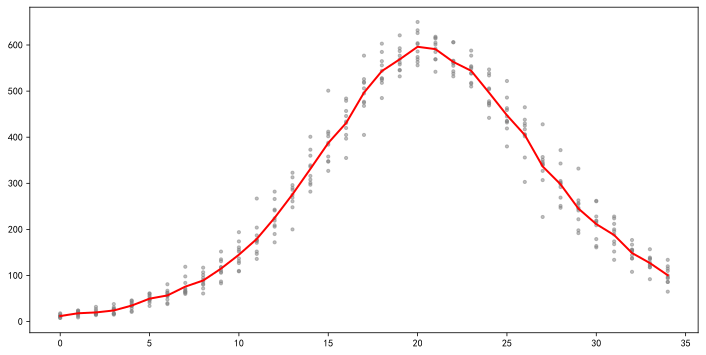

In [14]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
for line in diffu_cont:
    ax.scatter(np.arange(diffu.num_runs), line, color='grey', s=10, alpha=0.5)
ax.plot(np.mean(diffu_cont, axis=0), 'r-', lw=2)
plt.show()

In [19]:
p, q, m = 0.001, 0.05, 10000

## 准备数据

数据格式: x: [p, q, m, t, a(t-1)], y: [a(t)]

In [204]:
def prepare_one_data(ts_data, p, q, m):
    indep_data = []
    dep_data = []
    for i, ts in enumerate(ts_data):
        if i == 0:
            indep_data.append([p, q, m, 0, 0, ts])
        else:
            indep_data.append([p, q, m, np.sum(ts_data[:i]), ts_data[i-1], ts])

    return np.array(indep_data)

In [384]:
raw_data = prepare_one_data(diffu_cont[0], p, q, m)

In [385]:
raw_data.shape

(35, 6)

In [208]:
def prepare_dataset(ts_dataset, p, q, m):
    dataset = []
    for ts_data in ts_dataset:
        dataset.append(prepare_one_data(ts_data, p, q, m))
        
    return np.concatenate(dataset)

In [392]:
raw_dataset_list = []
for i, pq in enumerate(pq_cont):
    p, q = pq
    m = 10000
    raw_dataset_list.append(prepare_dataset(diff_list[i], p, q, m))

raw_dataset = np.concatenate(raw_dataset_list)

In [393]:
raw_dataset.shape

(3500, 6)

In [524]:
def data_iter(raw_dataset, batch_size=10, num_steps=35):
    X, y = raw_dataset[:,:-1], raw_dataset[:, -1]
    for i in range(len(raw_dataset) // (batch_size*num_steps)):
        yield (torch.FloatTensor(X[i*batch_size*num_steps: (i+1)*batch_size*num_steps]).reshape(batch_size, num_steps, -1), 
               torch.FloatTensor(y[i*batch_size*num_steps: (i+1)*batch_size*num_steps]).reshape(batch_size, num_steps, -1))

In [525]:
dataset = data_iter(raw_dataset)
for X, y in dataset:
    print(X.shape, y.shape)
    break

torch.Size([10, 35, 5]) torch.Size([10, 35, 1])


In [458]:
model = RnnModel(num_indepen, num_hidden, num_depen)
y,_ = model(X, state=None)

In [397]:
y.shape

torch.Size([10, 35, 1])

## 训练

In [684]:
a = X[5]
b = y[5]

In [685]:
b.reshape(-1)

tensor([  33.,   51.,   95.,  174.,  299.,  432.,  630.,  818., 1036., 1074.,
        1118., 1014.,  825.,  647.,  496.,  325.,  248.,  172.,  146.,   77.,
          55.,   35.,   31.,   22.,   24.,   18.,   14.,   13.,   10.,    5.,
           7.,    4.,    8.,    4.,    2.])

In [698]:
num_indepen = 5
num_depen = 1
num_hiddens1 = 256
num_hiddens2 = 16

model = ReviseRnnModel(num_indepen, num_hiddens1, num_hiddens2, num_depen)
loss = nn.MSELoss()  # 交叉熵损失函数

In [699]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.025)  # 优化算法
num_epochs = 2000
for i in range(num_epochs):
    optimizer.zero_grad()
    output, state = model(a.reshape(1, 35, 5), state=None)
    hat_y = output.reshape(-1)
    l = loss(b.reshape(-1), hat_y).mean()
    l.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i, l.detach().numpy())

0 213095.98
100 73828.03
200 27884.973
300 21564.217
400 17661.152
500 15330.901
600 14131.148
700 13652.189
800 13432.69
900 13704.245
1000 13261.357
1100 13219.602
1200 13193.169
1300 13175.144
1400 13563.067
1500 13157.0
1600 13152.724
1700 13195.097
1800 13148.876
1900 13148.129


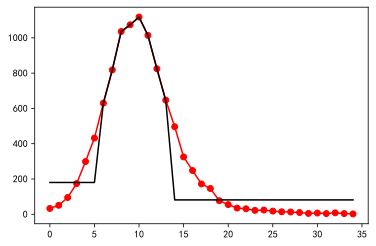

In [700]:
pred_b = model(a.reshape(1, 35, 5), state=None)[0].detach().numpy().reshape(-1)
plt.plot(b.reshape(-1).numpy(), 'ro-')
plt.plot(pred_b, 'k-')

In [678]:
num_indepen = 5
num_depen = 1
num_hidden = 32

model = RnnModel(num_indepen, num_hidden, num_depen)
loss = nn.MSELoss()  # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # 优化算法
num_epochs = 2000
for i in range(num_epochs):
    l_sum = 0.0
    dataset = data_iter(raw_dataset)
    for X, y in dataset:
        optimizer.zero_grad()
        output, state = model(X, state=None)
        hat_y = output.reshape(-1)
        l = loss(y.reshape(-1), hat_y).mean()
        l.backward()
        optimizer.step()
        l_sum += l.detach().numpy() * y.shape[0]
        
    if i % 50 == 0:
        print(i, l_sum)

0 11297767.021484375
50 6803866.689453125
100 6804636.630859375
150 6804917.8125
200 6805050.80078125
250 6805120.830078125
300 6805160.029296875
350 6805182.607421875
400 6805195.791015625
450 6805203.88671875
500 6805208.45703125
550 6805211.171875
600 6805212.939453125
650 6805213.525390625
700 6805214.658203125
750 6805214.4921875
800 6805214.8828125
850 6805215.3125
900 6805215.13671875
950 6805215.25390625
1000 6805215.126953125
1050 6805215.126953125
1100 6805215.126953125
1150 6805214.94140625
1200 6805214.94140625
1250 6805214.94140625
1300 6805214.94140625
1350 6805214.94140625
1400 6805214.94140625
1450 6805214.94140625
1500 6805214.94140625
1550 6805214.94140625
1600 6805214.94140625
1650 6805214.94140625
1700 6805214.94140625
1750 6805214.94140625
1800 6805214.94140625
1850 6805214.94140625
1900 6805214.94140625
1950 6805214.94140625


In [535]:
state = None
for i in range(3465, 3500):
    data = torch.FloatTensor(raw_dataset[i])
    x = data[:-1]
    y = data[-1:]
    output = model(x.reshape(1, 1, 5), state)
    hat_y = output[0].reshape(-1).detach()
    state = output[1]
    print(i, y[0], hat_y[0])

3465 tensor(43.) tensor(263.7214)
3466 tensor(80.) tensor(263.7214)
3467 tensor(121.) tensor(263.7214)
3468 tensor(184.) tensor(263.7214)
3469 tensor(300.) tensor(263.7214)
3470 tensor(434.) tensor(263.7214)
3471 tensor(636.) tensor(263.7214)
3472 tensor(815.) tensor(263.7214)
3473 tensor(1018.) tensor(263.7214)
3474 tensor(1142.) tensor(263.7214)
3475 tensor(1064.) tensor(263.7214)
3476 tensor(995.) tensor(263.7214)
3477 tensor(790.) tensor(263.7214)
3478 tensor(619.) tensor(263.7214)
3479 tensor(435.) tensor(263.7214)
3480 tensor(336.) tensor(263.7214)
3481 tensor(247.) tensor(263.7214)
3482 tensor(175.) tensor(263.7214)
3483 tensor(130.) tensor(263.7214)
3484 tensor(116.) tensor(263.7214)
3485 tensor(65.) tensor(263.7214)
3486 tensor(44.) tensor(263.7214)
3487 tensor(35.) tensor(263.7214)
3488 tensor(33.) tensor(263.7214)
3489 tensor(23.) tensor(263.7214)
3490 tensor(19.) tensor(263.7214)
3491 tensor(16.) tensor(263.7214)
3492 tensor(11.) tensor(263.7214)
3493 tensor(7.) tensor(263.

In [474]:
model(x.reshape(1, 1, 2))

(tensor([[[928.3801]]], grad_fn=<AddBackward0>),
 tensor([[[-1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,
            1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
           -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
           -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
            1.,  1., -1.,  1.,  1., -1., -1.,  1.]]], grad_fn=<StackBackward>))

In [402]:
hat_y

tensor([229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.5471,
        229.5471, 229.5471, 229.5471, 229.5471, 229.5471, 229.54

In [403]:
torch.mean(y)

tensor(284.5829)

In [404]:
torch.mean(hat_y)

tensor(229.5471, grad_fn=<MeanBackward0>)